In [3]:
!pip install optuna

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_recall_curve, auc, precision_score, recall_score
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
import pickle


data = pd.read_csv('unsw_datathon_2025.csv')
missing_data = round(data.isnull().mean() * 100, 1)

# dataset for Q3
selected_cols = ['age', 'addelassess', 'frailty', 'cogassess', 'cogstat', 'walk', 'uresidence', 'ftype', 'side', 'afracture',
                          'ptype', 'anaesth', 'wbear', 'pulcers', 'malnutrition', 'delay',
                          'delassess']
data_q3 = data[selected_cols]
# data_q3 = data_q3.dropna(subset=['delassess'])

# corr_matrix = data_q3.corr(numeric_only=True)

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title("Correlation Map of Features and Target (delassess)")
# plt.tight_layout()
# plt.show()
# Cross-entropy (log loss) on test set: 0.8349
# F1-score (macro): 0.4363
# Precision-Recall AUC (macro): 0.4861

temporal_cols = ['age', 'addelassess', 'frailty', 'cogassess', 'cogstat', 'walk', 'uresidence']  # specify your columns here

# Python
data_q3 = data_q3.copy()  # Make a copy before modifying

# Create lagged features
for col in temporal_cols:
    for lag in [1, 2, 3]:
        data_q3[f'{col}_lag_{lag}'] = data_q3[col].shift(lag)

# Create moving averages
for col in temporal_cols:
    data_q3[f'{col}_ma_3'] = data_q3[col].rolling(window=3).mean()

# Fill all NaNs after feature engineering
data_q3 = data_q3.fillna(data_q3.mean())

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
import optuna

# ...existing code...

X = data_q3.drop('delassess', axis=1)
y = pd.qcut(data_q3['delassess'], q=3, labels=[0, 1, 2])

# Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define base models
base_models = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)),
    ('rf', RandomForestClassifier())
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000)

def objective(trial):
    # Example: tune n_estimators for each base model
    params = {
        'xgb__n_estimators': trial.suggest_int('xgb_n_estimators', 50, 200),
        'rf__n_estimators': trial.suggest_int('rf_n_estimators', 50, 200),
    }
    estimators = [
        ('xgb', XGBClassifier(
    n_estimators=params['xgb__n_estimators'],
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=0
)),
        ('rf', RandomForestClassifier(
    n_estimators=params['rf__n_estimators'],
    max_depth=10,
    n_jobs=-1
))
    ]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_learner,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        passthrough=False
    )
    scores = cross_val_score(stack, X, y, cv=3, scoring='neg_log_loss', n_jobs=-1)
    return -scores.mean()

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best params:", study.best_params)
print("Best log loss:", study.best_value)


[I 2025-12-25 13:44:20,450] A new study created in memory with name: no-name-3404ed0d-29ce-4fd3-bfca-4677ee3e93cc
[I 2025-12-25 13:45:03,054] Trial 0 finished with value: 0.6376135426481558 and parameters: {'xgb_n_estimators': 73, 'rf_n_estimators': 189}. Best is trial 0 with value: 0.6376135426481558.
[I 2025-12-25 13:45:28,297] Trial 1 finished with value: 0.6378379206160427 and parameters: {'xgb_n_estimators': 58, 'rf_n_estimators': 60}. Best is trial 0 with value: 0.6376135426481558.
[I 2025-12-25 13:45:50,831] Trial 2 finished with value: 0.6375776880781907 and parameters: {'xgb_n_estimators': 73, 'rf_n_estimators': 69}. Best is trial 2 with value: 0.6375776880781907.
[I 2025-12-25 13:46:26,006] Trial 3 finished with value: 0.638043589553101 and parameters: {'xgb_n_estimators': 158, 'rf_n_estimators': 68}. Best is trial 2 with value: 0.6375776880781907.
[I 2025-12-25 13:47:37,485] Trial 4 finished with value: 0.638163625039211 and parameters: {'xgb_n_estimators': 183, 'rf_n_estima

Best params: {'xgb_n_estimators': 73, 'rf_n_estimators': 69}
Best log loss: 0.6375776880781907


In [5]:
# Train final model with best parameters
best_params = study.best_params
final_estimators = [
    ('xgb', XGBClassifier(
        n_estimators=best_params['xgb_n_estimators'],
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        eval_metric='logloss',
        verbosity=0
    )),
    ('rf', RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=10,
        n_jobs=-1
    ))
]

best_model = StackingClassifier(
    estimators=final_estimators,
    final_estimator=meta_learner,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    passthrough=False
)

best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
logloss = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

print("\n=== Model Performance Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"ROC-AUC (macro): {roc_auc:.4f}")

# Save the best model
with open('best_stacking_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("\nBest model saved to 'best_stacking_model.pkl'")

# Save model metrics
metrics_dict = {
    'accuracy': accuracy,
    'f1_score': f1_macro,
    'precision': precision_macro,
    'recall': recall_macro,
    'log_loss': logloss,
    'roc_auc': roc_auc,
    'best_params': best_params
}

with open('model_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)
print("Model metrics saved to 'model_metrics.pkl'")


=== Model Performance Metrics ===
Accuracy: 0.7168
F1-Score (macro): 0.6731
Precision (macro): 0.6836
Recall (macro): 0.6652
Log Loss: 0.6336
ROC-AUC (macro): 0.8480

Best model saved to 'best_stacking_model.pkl'
Model metrics saved to 'model_metrics.pkl'


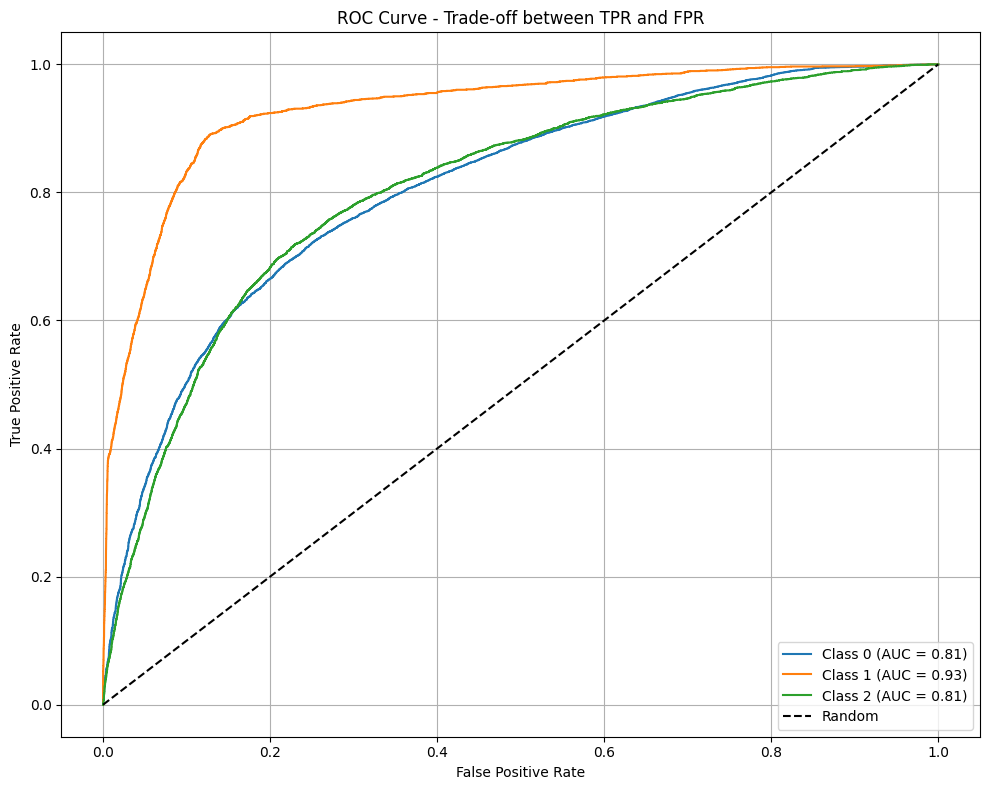

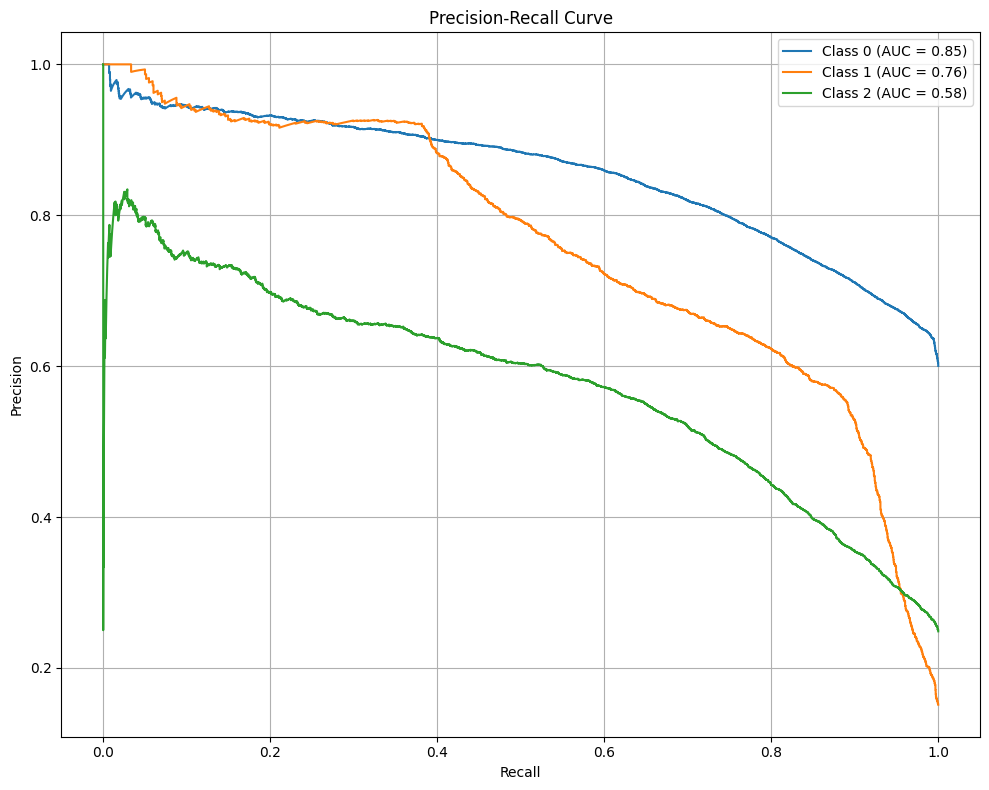

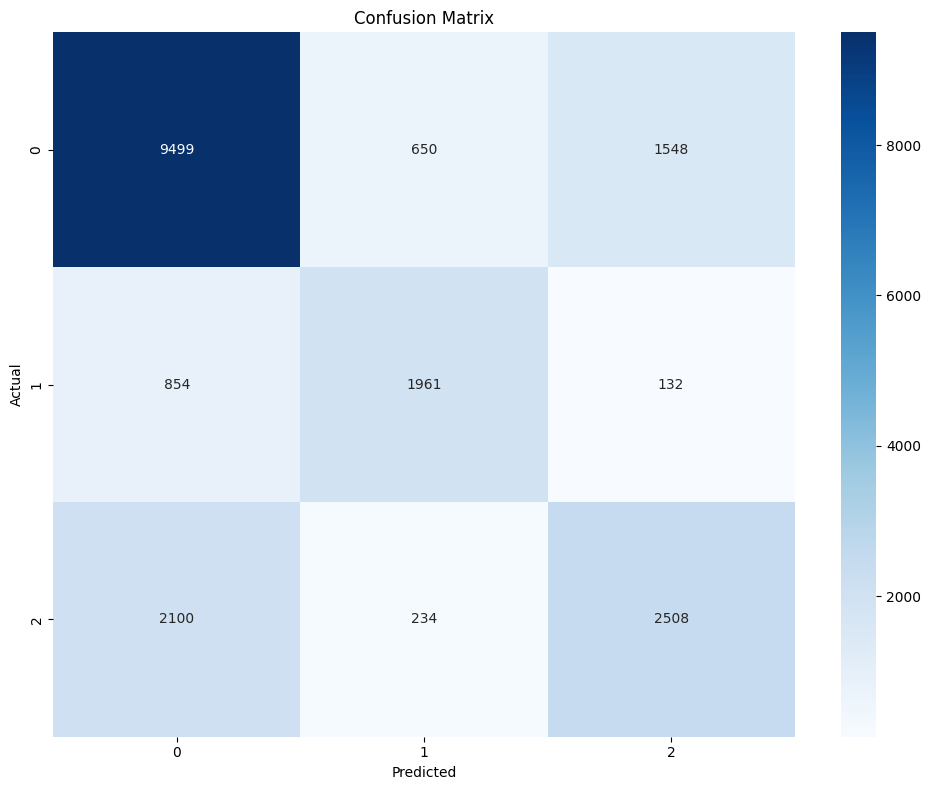

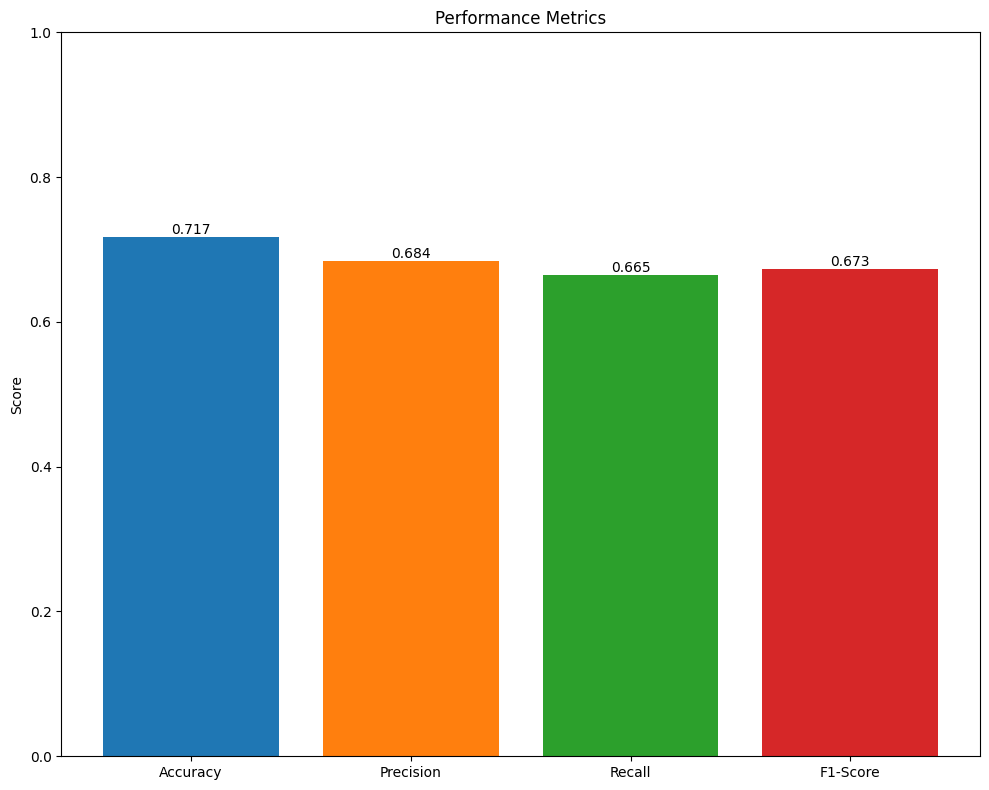

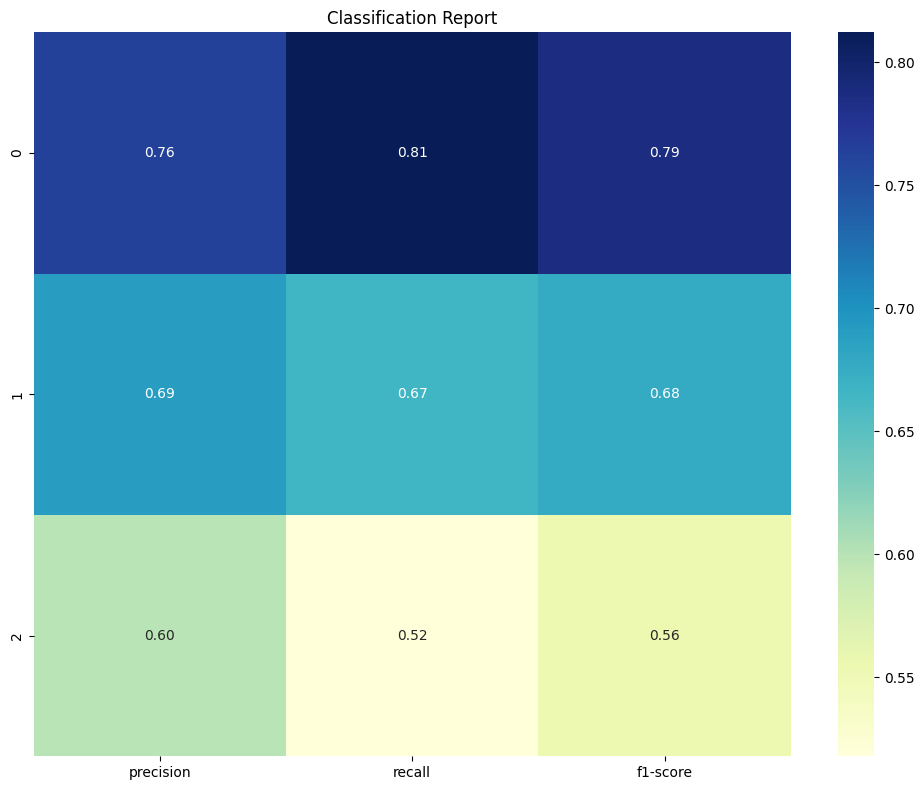

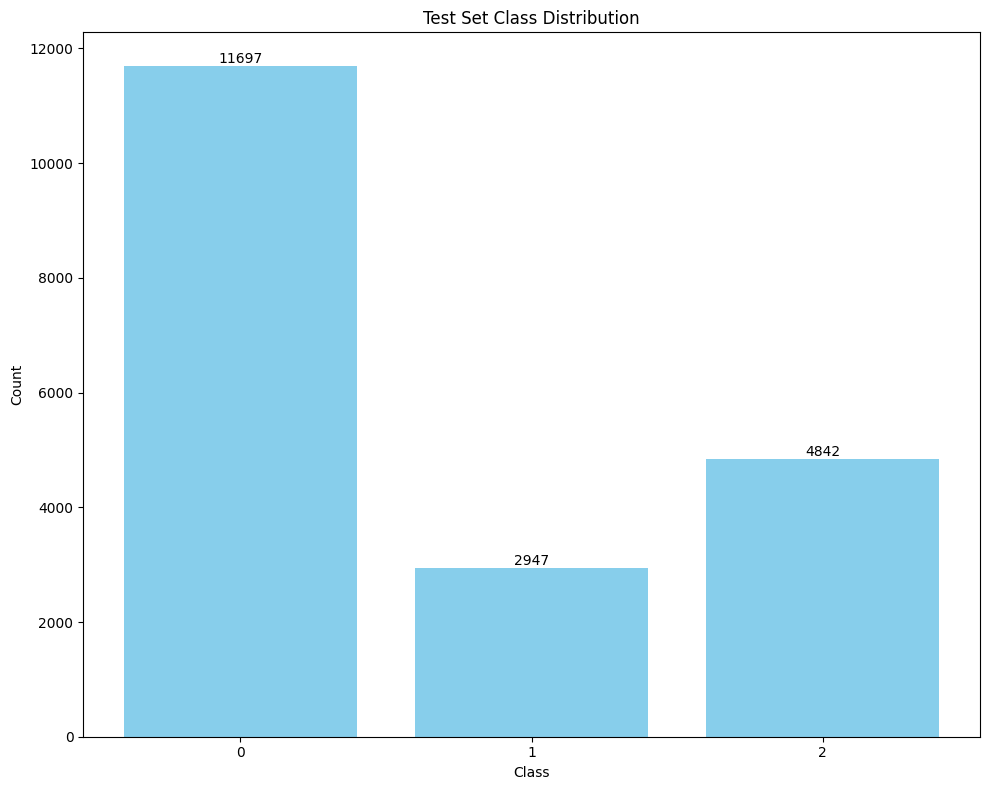


All evaluation metrics saved to 'evaluation_metrics/' folder:
  - roc_curve.png
  - precision_recall_curve.png
  - confusion_matrix.png
  - metrics_bar_chart.png
  - classification_report.png
  - class_distribution.png


In [6]:
import os

# Create evaluation_metrics folder if it doesn't exist
os.makedirs('evaluation_metrics', exist_ok=True)

# 1. ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Trade-off between TPR and FPR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('evaluation_metrics/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 2. Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'Class {i} (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('evaluation_metrics/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 3. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('evaluation_metrics/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 4. Metrics Bar Chart
plt.figure(figsize=(10, 8))
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision_macro, recall_macro, f1_macro]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim(0, 1)
plt.title('Performance Metrics')
plt.ylabel('Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('evaluation_metrics/metrics_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 5. Classification Report Heatmap
plt.figure(figsize=(10, 8))
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :3].T
sns.heatmap(report_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Classification Report')
plt.tight_layout()
plt.savefig('evaluation_metrics/classification_report.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 6. Class Distribution
plt.figure(figsize=(10, 8))
class_counts = pd.Series(y_test).value_counts().sort_index()
plt.bar(class_counts.index.astype(str), class_counts.values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test Set Class Distribution')
for i, v in enumerate(class_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('evaluation_metrics/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nAll evaluation metrics saved to 'evaluation_metrics/' folder:")
print("  - roc_curve.png")
print("  - precision_recall_curve.png")
print("  - confusion_matrix.png")
print("  - metrics_bar_chart.png")
print("  - classification_report.png")
print("  - class_distribution.png")